from distributed import Client
client = Client(n_workers = 2, threads_per_worker=1, memory_limit='5GB')
client

In [1]:
#written by Francis Osei Tutu Afrifa, 2022.

from warnings import filterwarnings

filterwarnings('ignore')

import sys
print(sys.prefix)

/glade/work/fafrifa/conda-envs/dynamics_class


In [2]:
%%time
import gc  ### import the garbage collector
import xarray as xr
import numpy as np
import francis_functions as ff  ### Import module named francis_functions containing defined functions as ff

gc.collect()   ### return the number of unreachable objects

CPU times: user 1.48 s, sys: 241 ms, total: 1.73 s
Wall time: 3.03 s


0

<b> Now let's read our .nc files by calling our defined data reader function (from module: francis_functions) on our specified variables </b>

In [4]:
%%time
path = '/glade/collections/rda/data/ds633.1/e5.moda.an.sfc/' #Directory where our netCDF datasets are located
data_vars = ['10u', '10v', '2d', '2t','msl']

"""
where:
10u = 10-m zonal wind (‘10u’) 
10v = 10-m meridional wind (‘10v’)
2d = 2-meter dewpoint temperature 
2t = 2-meter surface air temperature 
msl = Mean seal-level pressure
"""
loaded_data = ff.DataReader_l(data_vars, 1980, 2014,path,0,360,-90,90) ### reads variables and returns a dictionary containing loaded data
loaded_data

CPU times: user 1min 3s, sys: 14.5 s, total: 1min 18s
Wall time: 1min 39s


{'10u': <xarray.Dataset>
 Dimensions:    (time: 420, latitude: 721, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
   * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
   * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2014-12-01
 Data variables:
     VAR_10U    (time, latitude, longitude) float32 0.01141 0.01141 ... 0.3639
     utc_date   (time) int32 1980010100 1980020100 ... 2014110100 2014120100
 Attributes:
     DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
     NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
     NETCDF_VERSION:       4.6.1
     CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
     CONVERSION_DATE:      Mon Nov 11 08:03:22 MST 2019
     Conventions:          CF-1.6
     NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
     history:              

In [5]:
%%time
_10u = loaded_data['10u']   #retrieve 10u data from dictionary and assign it to variable _10u
_10v = loaded_data['10v']   #retrieve 10v data from dictionary and assign it to variable _10v
_2d = loaded_data['2d']  #retrieve 2d data from dictionary and assign it to variable _2d
_2t = loaded_data['2t']   #retrieve 2t data from dictionary and assign it to variable _2t
_msl = loaded_data['msl']  #retrieve msl data from dictionary and assign it to variable _msl

gc.collect()

CPU times: user 85.4 ms, sys: 0 ns, total: 85.4 ms
Wall time: 111 ms


2019

<b/> To generate the linear trends for each data, calculate slope for every individual spatial grid point using stats.linregress </b>

In [6]:
%%time
_10uTrend = ff.trends(_10u['VAR_10U'])
_10vTrend = ff.trends(_10v['VAR_10V'])
_2dTrend = ff.trends(_2d['VAR_2D'])
_2tTrend = ff.trends(_2t['VAR_2T'])
_mslTrend = ff.trends(_msl['MSL']/100)  ### Convert Pressure from Pa to hPa (10**2 Pa)

gc.collect()

CPU times: user 20min 57s, sys: 12.5 s, total: 21min 10s
Wall time: 21min 50s


0

<b/> Now Let's combine (using xarray.merge) the computed trends (xarray.DataArray) into a single xarray.Dataset </b>

In [8]:
%%time
import xarray as xr
combinedTrend = xr.merge([_10uTrend,_10vTrend,_2dTrend,_2tTrend,_mslTrend])
combinedTrend

CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 2.02 ms


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    VAR_10U    (latitude, longitude) float64 -9.766e-06 -9.766e-06 ... 4.172e-05
    VAR_10V    (latitude, longitude) float64 6.952e-05 6.952e-05 ... -1.624e-05
    VAR_2D     (latitude, longitude) float64 0.004846 0.004846 ... -0.002244
    VAR_2T     (latitude, longitude) float64 0.004225 0.004225 ... -0.002202
    MSL        (latitude, longitude) float64 0.001246 0.001246 ... 0.000158

<b/> Convert this dataset to a single netcdf file </b>

In [9]:
%%time
combinedTrend.to_netcdf('./%s.nc' %('/computedTrends/surface_trends'))
gc.collect()

CPU times: user 94.2 ms, sys: 24.9 ms, total: 119 ms
Wall time: 294 ms


44

<b/> Now Let's read and work with this new .nc file (containing the computed trends) </b>

In [3]:
%%time
d_trend = xr.open_dataset('./%s.nc' %('/computedTrends/surface_trends'))
d_trend = d_trend.load()    ### Read file containing computed surface trends and load it into a variable named d_trend
d_trend

CPU times: user 9.64 ms, sys: 29.8 ms, total: 39.5 ms
Wall time: 76 ms


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    VAR_10U    (latitude, longitude) float64 -9.766e-06 -9.766e-06 ... 4.172e-05
    VAR_10V    (latitude, longitude) float64 6.952e-05 6.952e-05 ... -1.624e-05
    VAR_2D     (latitude, longitude) float64 0.004846 0.004846 ... -0.002244
    VAR_2T     (latitude, longitude) float64 0.004225 0.004225 ... -0.002202
    MSL        (latitude, longitude) float64 0.001246 0.001246 ... 0.000158

<b/> <span style="color:red"> 2-m temperature trend (1980-2014 mean) [K/century] </span> </b>

CPU times: user 17.2 s, sys: 159 ms, total: 17.4 s
Wall time: 18.1 s


68

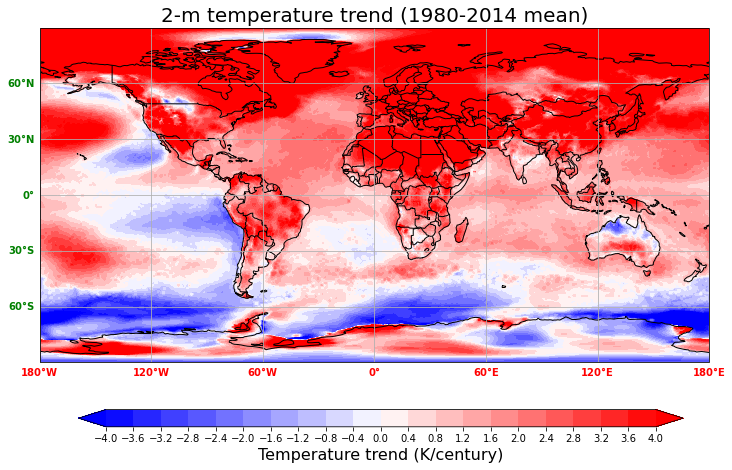

In [12]:
%%time
ff.contourfPlot(data = d_trend['VAR_2T']*12*100, color_map = 'bwr', title = '2-m temperature trend (1980-2014 mean)',
                cbar_label = 'Temperature trend (K/century)', filename = '2mTemp-trend', levels = np.arange(-4,4.4,0.4))
gc.collect()

<b/> <span style="color:red"> 2-m dewpoint temperature trend (1980-2014 mean) [K/century] </span> </b>

CPU times: user 14.8 s, sys: 164 ms, total: 15 s
Wall time: 15.3 s


13646

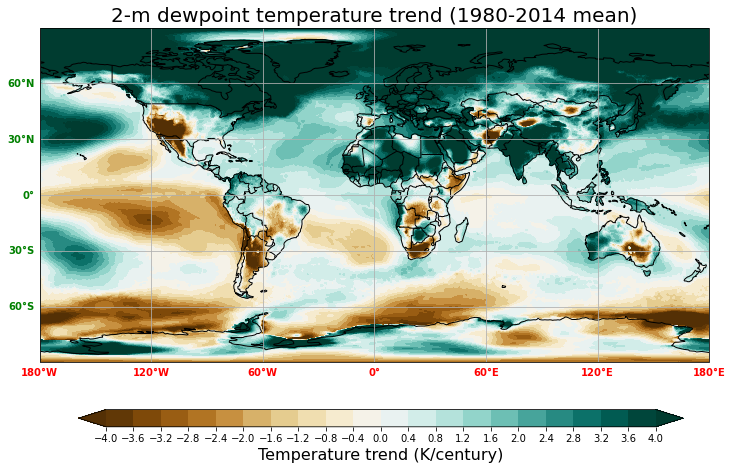

In [13]:
%%time
ff.contourfPlot(data = d_trend['VAR_2D']*12*100, color_map = 'BrBG', title = '2-m dewpoint temperature trend (1980-2014 mean)',
                cbar_label = 'Temperature trend (K/century)', filename = '2dTemp-trend', levels=np.arange(-4,4.4,0.4))
gc.collect()

<b/> <span style="color:red"> Mean Sea Level (MSL) Pressure trend (1980-2014 mean) [hPa/century] </span> </b>

CPU times: user 5.96 s, sys: 67 ms, total: 6.03 s
Wall time: 6.33 s


13935

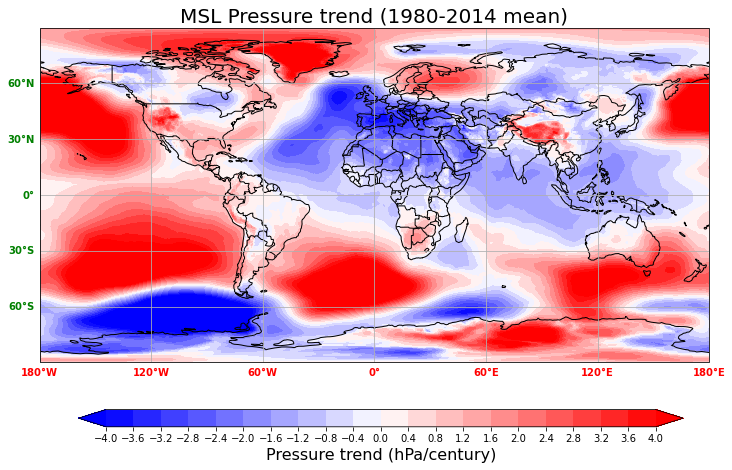

In [14]:
%%time
ff.contourfPlot(data = d_trend['MSL']*12*100, color_map = 'bwr', title = 'MSL Pressure trend (1980-2014 mean)',
                cbar_label = 'Pressure trend (hPa/century)', filename = 'msl-trend', levels=np.arange(-4,4.4,0.4))
gc.collect()

<b/> <span style="color:blue">Mean Sea Level (MSL) Pressure trend with wind barbs overlaid (1980-2014) [hPa/century] </span> </b>

CPU times: user 5.41 s, sys: 73.3 ms, total: 5.49 s
Wall time: 5.57 s


183

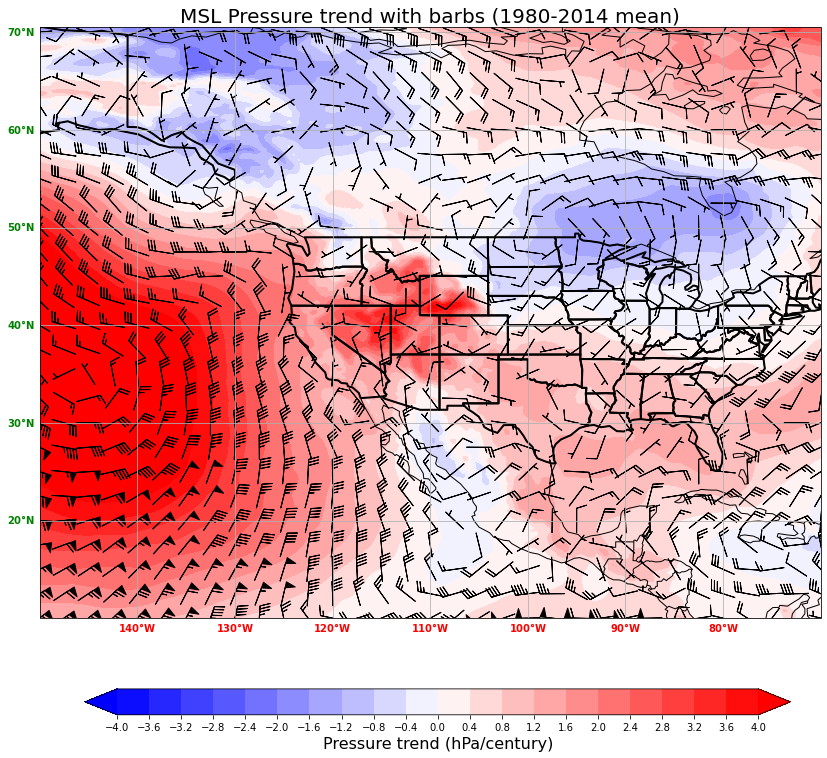

In [4]:
%%time
ff.plotScalarAndWinds(data = d_trend['MSL']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'bwr',
                   title = 'MSL Pressure trend with barbs (1980-2014 mean)', cbar_label = 'Pressure trend (hPa/century)',
                   filename = 'msl-trendBarbs', levels=np.arange(-4,4.4,0.4))
gc.collect()

<b/> <span style="color:blue"> 2-m Temperature trend with wind barbs overlaid (1980-2014) [K/century] </span> </b>

CPU times: user 17.8 s, sys: 217 ms, total: 18.1 s
Wall time: 18.6 s


19530

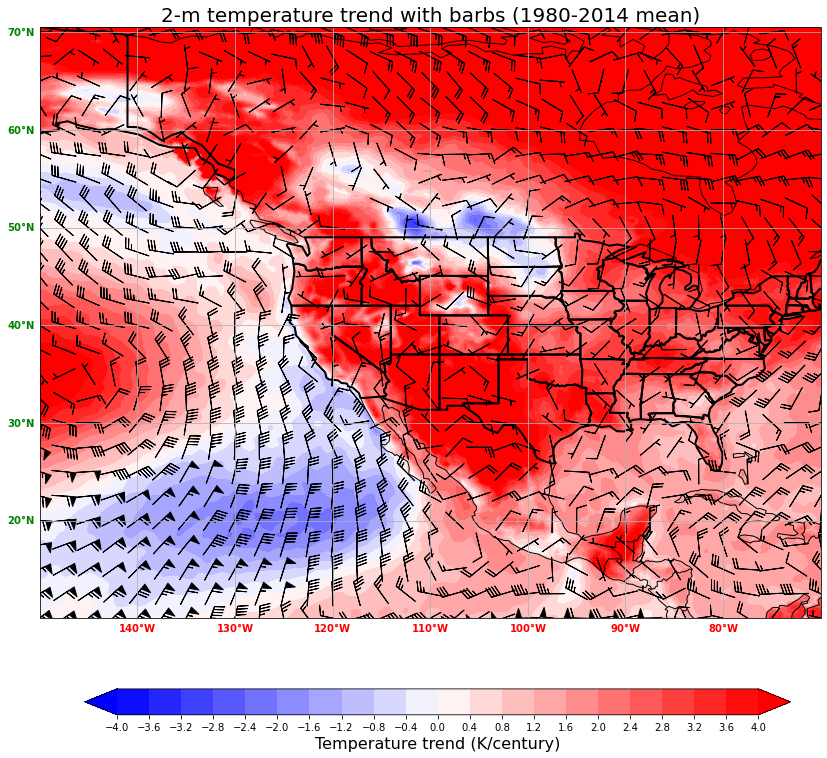

In [17]:
%%time
ff.plotScalarAndWinds(data = d_trend['VAR_2T']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'bwr',
                   title = '2-m temperature trend with barbs (1980-2014 mean)', cbar_label ='Temperature trend (K/century)',
                   filename = '2mTemp-trendBarbs', levels=np.arange(-4,4.4,0.4))
gc.collect()

<b/> <span style="color:blue"> 2-m Dewpoint temperature trend with wind barbs overlaid (1980-2014) [K/century] </span> </b>

CPU times: user 15.4 s, sys: 193 ms, total: 15.6 s
Wall time: 16.1 s


24379

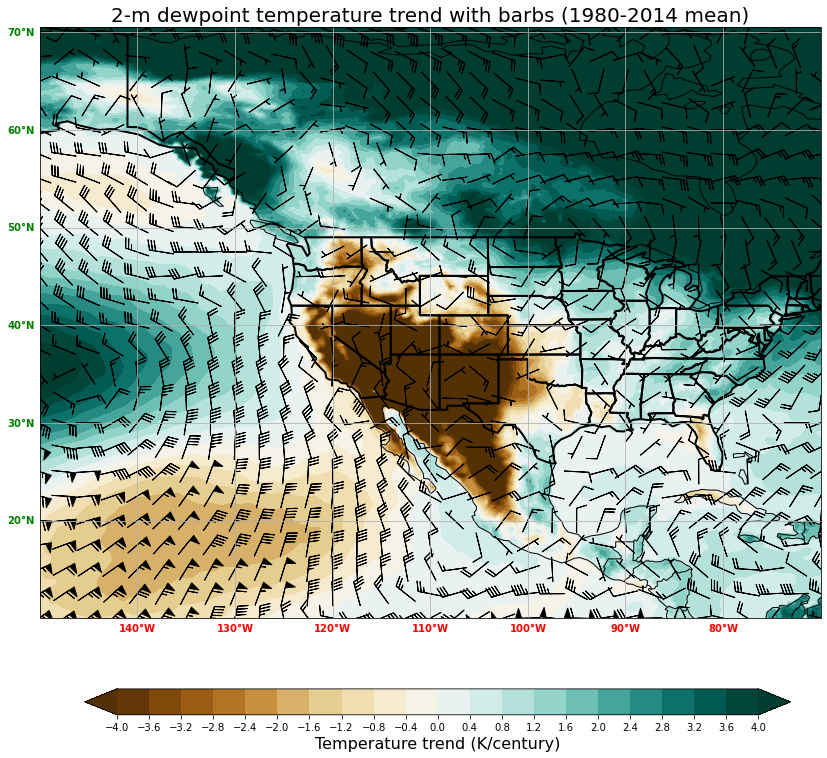

In [18]:
%%time
ff.plotScalarAndWinds(data = d_trend['VAR_2D']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'BrBG',
                   title = '2-m dewpoint temperature trend with barbs (1980-2014 mean)', cbar_label ='Temperature trend (K/century)',
                   filename = '2dTemp-trendBarbs', levels=np.arange(-4,4.4,0.4))
gc.collect()

## FOR PRECIPITATION RATE AND WIND SPEED: ##

<b> Now let's read our .nc files (precipitation rate) by calling our defined data reader function (from module: francis_functions) on our specified variables </b>

In [19]:
%%time
path = '/glade/collections/rda/data/ds633.1/e5.moda.fc.sfc.instan/' ### Directory where our netCDF datasets are located
data_vars = ['crr', 'lsrr']

"""
where:
crr = convective rain rate (kg m**-2 s**-1) 
lsrr = large scale rain rate (kg m**-2 s**-1)
"""
pre_data = ff.DataReader_l(data_vars, 1980, 2014,path,0,360,-90,90) ### reads variables and returns a dictionary containing loaded data
pre_data

CPU times: user 23.3 s, sys: 5.84 s, total: 29.2 s
Wall time: 39.5 s


{'crr': <xarray.Dataset>
 Dimensions:    (time: 420, latitude: 721, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
   * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
   * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2014-12-01
 Data variables:
     CRR        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
     utc_date   (time) int32 1980010100 1980020100 ... 2014110100 2014120100
 Attributes:
     DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
     NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
     NETCDF_VERSION:       4.6.1
     CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
     CONVERSION_DATE:      Mon Nov 11 08:58:44 MST 2019
     Conventions:          CF-1.6
     NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
     history:             

In [21]:
%%time
_crr = pre_data['crr']   #retrieve crr data from dictionary and assign it to variable _crr
_lsrr = pre_data['lsrr']   #retrieve lsrr data from dictionary and assign it to variable _lsrr
gc.collect()

CPU times: user 101 ms, sys: 19.9 ms, total: 121 ms
Wall time: 147 ms


296

<b/> To generate the linear trends for each data, calculate slope for every individual spatial grid point using stats.linregress </b>

In [22]:
%%time
_crrTrend = ff.trends(_crr['CRR']*86400) ## Multiply by *86400 to convert rain rate from kg m**-2 s**-1 to mm/day
_lsrrTrend = ff.trends(_lsrr['LSRR']*86400) ## Multiply by *86400 to convert rain rate from kg m**-2 s**-1 to mm/day

### For Total Precipitation rate trend:
_trrTrend = _crrTrend+_lsrrTrend   ### Sum of trends in convective and large-scale rain rates
_trrTrend.name = 'TRR'
gc.collect()

CPU times: user 8min 7s, sys: 9.41 s, total: 8min 16s
Wall time: 8min 34s


0

<b/> For wind speed: </b>

In [24]:
%%time
_uv_speed = ff.wind_uv_speed(_10u['VAR_10U'],_10v['VAR_10V'])
_windSpeedTrend = ff.trends(_uv_speed)
_windSpeedTrend.name = 'Wind Speed'
_windSpeedTrend

CPU times: user 4min 12s, sys: 6.2 s, total: 4min 18s
Wall time: 4min 26s


<xarray.DataArray 'Wind Speed' (latitude: 721, longitude: 1440)>
array([[-7.19358167e-06, -7.19358167e-06, -7.19358167e-06, ...,
        -7.19358167e-06, -7.19358167e-06, -7.19358167e-06],
       [-3.97520297e-04, -3.96861628e-04, -3.96344946e-04, ...,
        -3.98709904e-04, -3.98269179e-04, -3.97905598e-04],
       [-4.46591736e-04, -4.45986687e-04, -4.45221669e-04, ...,
        -4.47585437e-04, -4.47165102e-04, -4.46824143e-04],
       ...,
       [ 7.17937344e-04,  7.18240673e-04,  7.18235505e-04, ...,
         7.16687962e-04,  7.17208807e-04,  7.17599398e-04],
       [ 6.89073419e-04,  6.89367485e-04,  6.89468600e-04, ...,
         6.87778617e-04,  6.88143911e-04,  6.88605915e-04],
       [ 4.03946139e-05,  4.03946139e-05,  4.03946139e-05, ...,
         4.03946139e-05,  4.03946139e-05,  4.03946139e-05]])
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

<b/> Now Let's combine (using xarray.merge) these newly computed trends (xarray.DataArray) into a single xarray.Dataset: </b>

In [25]:
%%time
combined_surTrends = xr.merge([_crrTrend, _lsrrTrend, _trrTrend, _windSpeedTrend])
combined_surTrends

CPU times: user 726 µs, sys: 975 µs, total: 1.7 ms
Wall time: 1.71 ms


<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    CRR         (latitude, longitude) float64 -1.557e-06 -1.557e-06 ... 0.0 0.0
    LSRR        (latitude, longitude) float64 -2.891e-05 -2.891e-05 ... 0.0 0.0
    TRR         (latitude, longitude) float64 -3.046e-05 -3.046e-05 ... 0.0 0.0
    Wind Speed  (latitude, longitude) float64 -7.194e-06 ... 4.039e-05

<b/> And then convert this single dataset to a netcdf file: </b>

In [26]:
%%time
combined_surTrends.to_netcdf('./%s.nc' %('/computedTrends/pre & WdSpd_trends'))
gc.collect()

CPU times: user 114 ms, sys: 29.8 ms, total: 144 ms
Wall time: 261 ms


66

<b/> Now Let's read and work with this new .nc file (containing the computed trends): </b>

In [6]:
%%time
pre_WSpd_Trend = xr.open_dataset('./%s.nc' %'/computedTrends/pre & WdSpd_trends')
pre_WSpd_Trend = pre_WSpd_Trend.load()    ### Read file containing computed surface trends and load it into a variable named d_trend
pre_WSpd_Trend

CPU times: user 7.66 ms, sys: 12.1 ms, total: 19.8 ms
Wall time: 159 ms


<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    CRR         (latitude, longitude) float64 -1.557e-06 -1.557e-06 ... 0.0 0.0
    LSRR        (latitude, longitude) float64 -2.891e-05 -2.891e-05 ... 0.0 0.0
    TRR         (latitude, longitude) float64 -3.046e-05 -3.046e-05 ... 0.0 0.0
    Wind Speed  (latitude, longitude) float64 -7.194e-06 ... 4.039e-05

<b/> <span style="color:green"> Wind Speed trend with wind barbs overlaid (1980-2014) [m/s/century] </span> </b>

CPU times: user 18.5 s, sys: 72.7 ms, total: 18.5 s
Wall time: 19.5 s


23870

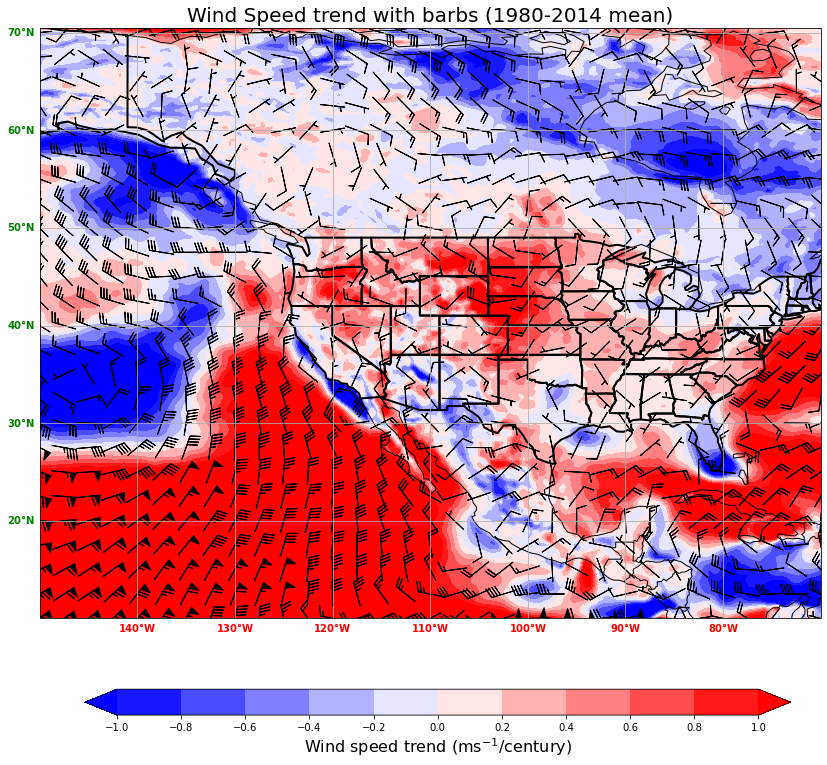

In [7]:
%%time
ff.plotScalarAndWinds(data = pre_WSpd_Trend['Wind Speed']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'bwr',
                   title = 'Wind Speed trend with barbs (1980-2014 mean)',cbar_label = 'Wind speed trend (ms$^{-1}$/century)',
                   filename = 'windspeed-trendBarbs', levels=np.arange(-1,1.2,0.2))
gc.collect()

<b/> <span style="color:green"> Convective Rain Rate (CRR) Trend with wind barbs overlaid (1980-2014) [mm/day/century] </span> </b>

CPU times: user 4min 29s, sys: 2.65 s, total: 4min 32s
Wall time: 4min 40s


5

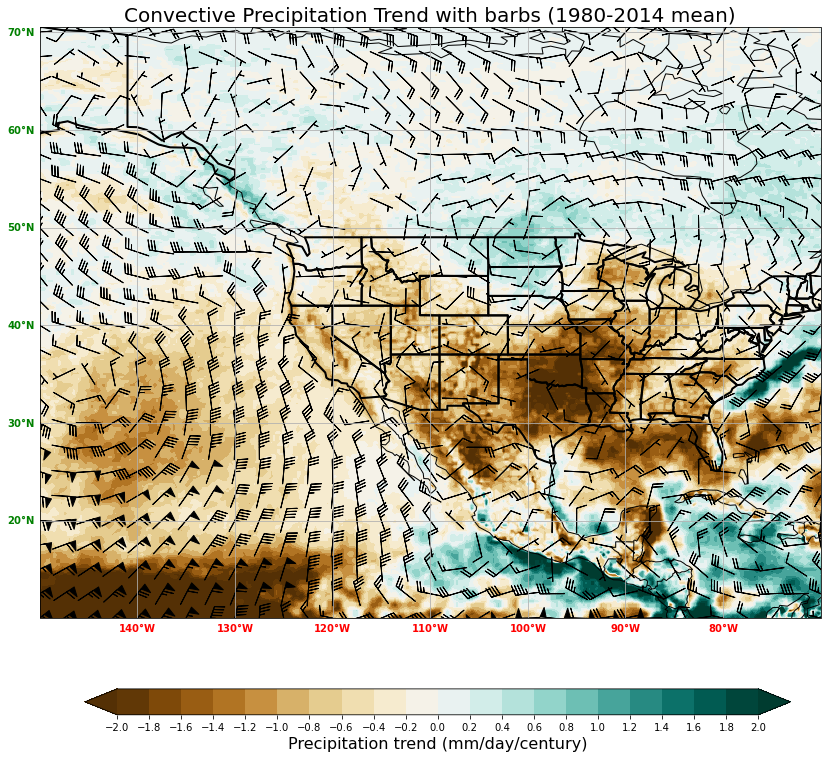

In [29]:
%%time
ff.plotScalarAndWinds(data = pre_WSpd_Trend['CRR']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'BrBG',
                   title = 'Convective Precipitation Trend with barbs (1980-2014 mean)', cbar_label = 'Precipitation trend (mm/day/century)',
                   filename = 'crr-trendBarbs', levels=np.arange(-2,2.2,0.2))
gc.collect()

<b/> <span style="color:green"> Large-scale Rain Rate (LSRR) Trend with wind barbs overlaid (1980-2014) [mm/day/century] </span> </b>

CPU times: user 53.7 s, sys: 573 ms, total: 54.3 s
Wall time: 56.1 s


0

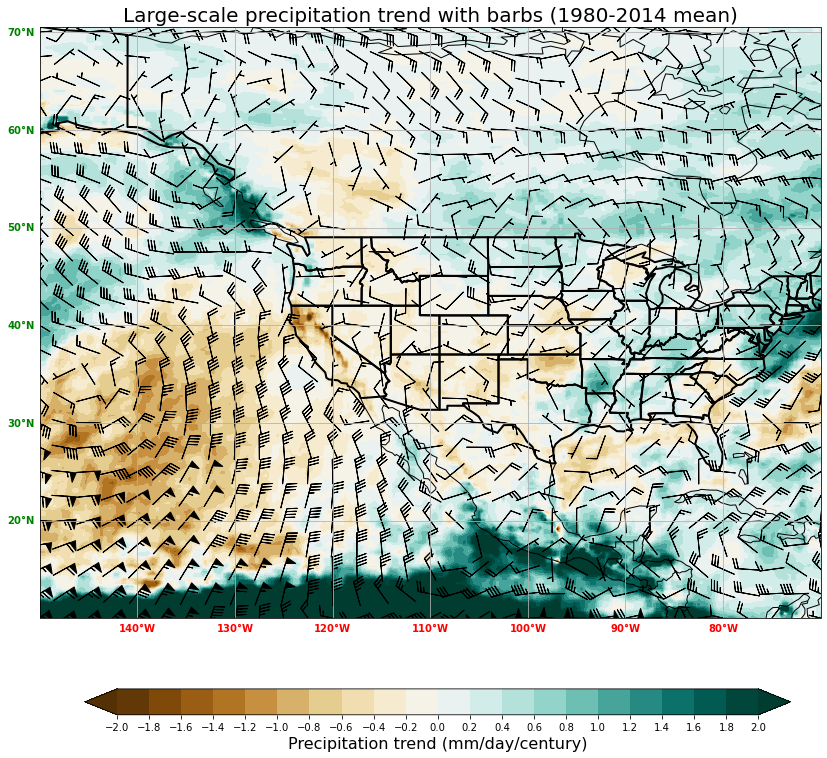

In [30]:
%%time
ff.plotScalarAndWinds(data = pre_WSpd_Trend['LSRR']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'BrBG',
                   title = 'Large-scale precipitation trend with barbs (1980-2014 mean)', cbar_label = 'Precipitation trend (mm/day/century)',
                   filename = 'lsrr-trendBarbs', levels=np.arange(-2,2.2,0.2))
gc.collect()

<b/> <span style="color:green"> Total Rain Rate (TRR) Trend with wind barbs overlaid (1980-2014) [mm/day/century] </span> </b>

CPU times: user 1min 38s, sys: 1.07 s, total: 1min 39s
Wall time: 1min 41s


15

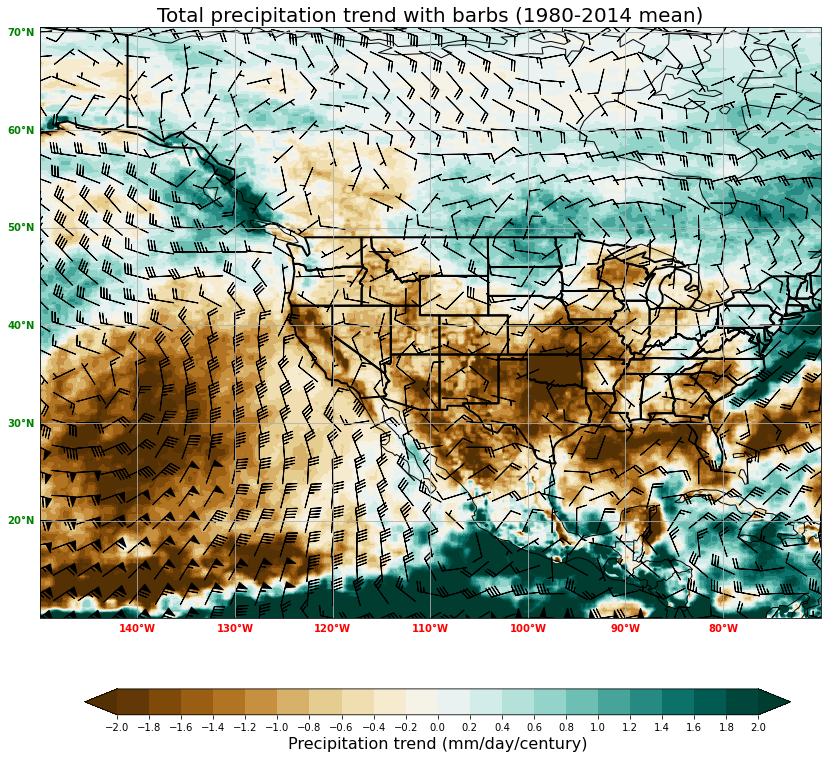

In [31]:
%%time
ff.plotScalarAndWinds(data = pre_WSpd_Trend['TRR']*12*100, uwind = d_trend['VAR_10U']*1.94384, vwind = d_trend['VAR_10V']*1.94384, color_map = 'BrBG',
                   title = 'Total precipitation trend with barbs (1980-2014 mean)', cbar_label = 'Precipitation trend (mm/day/century)',
                   filename = 'trr-trendBarbs', levels=np.arange(-2,2.2,0.2))
gc.collect()